# Train a neural network with lyrics from an Irish song then let it make a new song for you.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers

## Get the Data

In [ ]:
data = "In the town of Athy one Jeremy Lanigan \n Battered away til he hadnt a pound. \nHis father died and made him a man again \n Left him a farm and ten acres of ground. \nHe gave a grand party for friends and relations \nWho didnt forget him when come to the wall, \nAnd if youll but listen Ill make your eyes glisten \nOf the rows and the ructions of Lanigans Ball. \nMyself to be sure got free invitation, \nFor all the nice girls and boys I might ask, \nAnd just in a minute both friends and relations \nWere dancing round merry as bees round a cask. \nJudy ODaly, that nice little milliner, \nShe tipped me a wink for to give her a call, \nAnd I soon arrived with Peggy McGilligan \nJust in time for Lanigans Ball. \nThere were lashings of punch and wine for the ladies, \nPotatoes and cakes; there was bacon and tea, \nThere were the Nolans, Dolans, OGradys \nCourting the girls and dancing away. \nSongs they went round as plenty as water, \nThe harp that once sounded in Taras old hall,\nSweet Nelly Gray and The Rat Catchers Daughter,\nAll singing together at Lanigans Ball. \nThey were doing all kinds of nonsensical polkas \nAll round the room in a whirligig. \nJulia and I, we banished their nonsense \nAnd tipped them the twist of a reel and a jig. \nAch mavrone, how the girls got all mad at me \nDanced til youd think the ceiling would fall. \nFor I spent three weeks at Brooks Academy \nLearning new steps for Lanigans Ball. \nThree long weeks I spent up in Dublin, \nThree long weeks to learn nothing at all,\n Three long weeks I spent up in Dublin, \nLearning new steps for Lanigans Ball. \nShe stepped out and I stepped in again, \nI stepped out and she stepped in again, \nShe stepped out and I stepped in again, \nLearning new steps for Lanigans Ball. \nBoys were all merry and the girls they were hearty \nAnd danced all around in couples and groups, \nTil an accident happened, young Terrance McCarthy \nPut his right leg through miss Finnertys hoops. \nPoor creature fainted and cried Meelia murther, \nCalled for her brothers and gathered them all. \nCarmody swore that hed go no further \nTil he had satisfaction at Lanigans Ball. \nIn the midst of the row miss Kerrigan fainted, \nHer cheeks at the same time as red as a rose. \nSome of the lads declared she was painted, \nShe took a small drop too much, I suppose. \nHer sweetheart, Ned Morgan, so powerful and able, \nWhen he saw his fair colleen stretched out by the wall, \nTore the left leg from under the table \nAnd smashed all the Chaneys at Lanigans Ball. \nBoys, oh boys, twas then there were runctions. \nMyself got a lick from big Phelim McHugh. \nI soon replied to his introduction \nAnd kicked up a terrible hullabaloo. \nOld Casey, the piper, was near being strangled. \nThey squeezed up his pipes, bellows, chanters and all. \nThe girls, in their ribbons, they got all entangled \nAnd that put an end to Lanigans Ball."

corpus = data.lower().split("\n")
corpus

['in the town of athy one jeremy lanigan ',
 ' battered away til he hadnt a pound. ',
 'his father died and made him a man again ',
 ' left him a farm and ten acres of ground. ',
 'he gave a grand party for friends and relations ',
 'who didnt forget him when come to the wall, ',
 'and if youll but listen ill make your eyes glisten ',
 'of the rows and the ructions of lanigans ball. ',
 'myself to be sure got free invitation, ',
 'for all the nice girls and boys i might ask, ',
 'and just in a minute both friends and relations ',
 'were dancing round merry as bees round a cask. ',
 'judy odaly, that nice little milliner, ',
 'she tipped me a wink for to give her a call, ',
 'and i soon arrived with peggy mcgilligan ',
 'just in time for lanigans ball. ',
 'there were lashings of punch and wine for the ladies, ',
 'potatoes and cakes; there was bacon and tea, ',
 'there were the nolans, dolans, ogradys ',
 'courting the girls and dancing away. ',
 'songs they went round as plenty as wat

## Data Preprocessing

In [ ]:
vectorizer = tf.keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation')
vectorizer.adapt(corpus)

In [ ]:
vocab = vectorizer.get_vocabulary()
print(vocab[:50])
print(len(vocab))

['', '[UNK]', 'and', 'the', 'a', 'in', 'all', 'i', 'for', 'of', 'lanigans', 'ball', 'were', 'at', 'to', 'stepped', 'she', 'they', 'his', 'girls', 'as', 'weeks', 'up', 'til', 'three', 'there', 'that', 'round', 'out', 'her', 'he', 'got', 'boys', 'again', 'was', 'steps', 'spent', 'new', 'long', 'learning', 'him', 'when', 'wall', 'tipped', 'time', 'them', 'their', 'soon', 'relations', 'put']
264


In [ ]:
input_sequences = []

for line in corpus:
    tokenized_line = vectorizer(line).numpy()
    for i in range(1, len(tokenized_line)):
        n_gram_sequence = tokenized_line[:i+1]
        input_sequences.append(n_gram_sequence)

# get the maxlen sent
max_len = max([len(seq) for seq in input_sequences])

# pad sequences
padded_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen = max_len, padding='pre'))

# split data into input and output
input_sequences = padded_sequences[:, :-1]
target_sequences = padded_sequences[:, -1]

# encode labels
target_sequences = tf.keras.utils.to_categorical(target_sequences, num_classes = len(vocab))

In [ ]:
def sequence_to_text(sequence, vocab):
  words = [vocab[i] for i in sequence]

  # decode words
  sent = tf.strings.reduce_join(words, separator=' ')

  return sent.numpy().decode('utf-8')

sequence = input_sequences[6]
print(sequence)
sequence_to_text(sequence, vocab)

[  0   0   0   5   3  83   9 255 140 183]


'   in the town of athy one jeremy'

## Build Model

In [ ]:
tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    layers.Input(shape = (max_len - 1, ), name = 'Input'),
    layers.Embedding(input_dim = len(vocab), output_dim = 64, input_length = max_len-1),
    layers.Bidirectional(layers.LSTM(64, return_sequences = True)),
    layers.Bidirectional(layers.LSTM(64)),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(len(vocab), activation = 'softmax')
], name = 'model_1')

model_1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model_1.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 10, 64)              │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 10, 128)             │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 264)                 │          17,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 207,176 (809.28 KB)

 Trainable params: 207,176 (809.28 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_1 = model_1.fit(input_sequences, target_sequences, epochs = 500)

Epoch 1/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.0233 - loss: 5.5726
Epoch 2/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.0500 - loss: 5.4799
Epoch 3/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0507 - loss: 5.2706
Epoch 4/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.0475 - loss: 5.1489
Epoch 5/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0467 - loss: 5.0650
Epoch 6/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.0484 - loss: 4.9632
Epoch 7/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0577 - loss: 4.8713
Epoch 8/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0483 - loss: 4.7299
Epoch 9/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.0529 - loss: 4.5740
Epoch 10/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.0671 - loss: 4.4505
Epoch 11/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0664 - loss: 4.4028
Epoch 12/500
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

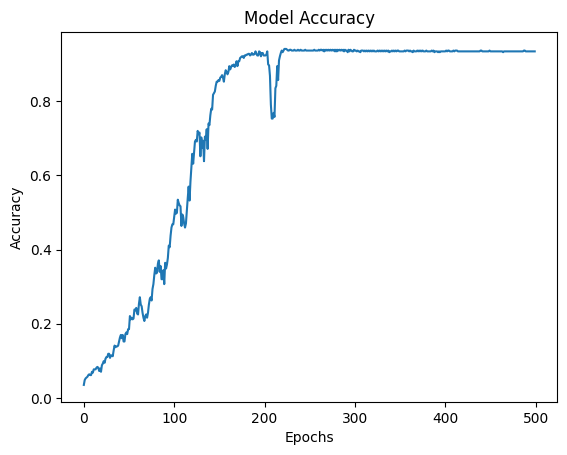

In [ ]:
# plot the accuracy
plt.plot(history_1.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

## Generating text based on the input


In [ ]:
def generate_text(model, seed_text, next_words, max_sequence_len, vocab):
    for _ in range(next_words):
        token_list = vectorizer(seed_text).numpy()
        pad_sequence = np.array(tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
        predicted = np.argmax(model.predict(pad_sequence), axis=-1)
        if predicted == 0:
            continue

        output_word = vocab[predicted[0]]
        seed_text += " " + output_word
    return seed_text

text = generate_text(model_1, 'in the town of athy', 10, max_len, vocab)
print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
in the town of athy one jeremy lanigan hall eyes runctions entangled all were by


#### In the output above, you might notice frequent repetition of words the longer the sentence gets. There are ways to get around it and the next cell shows one. Basically, instead of getting the index with max probability, you will get the top three indices and choose one at random. See if the output text makes more sense with this approach. This is not the most time efficient solution because it is always sorting the entire array even if you only need the top three.

In [ ]:
text = generate_text(model_1, 'Laurence went to Dublin', 10, max_len, vocab)
print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Laurence went to Dublin cried away the cask fainted by nothing hearty hearty got


In [ ]:
def generate_text(model, seed_text, next_words, max_sequence_len, vocab):
    for _ in range(next_words):
        token_list = vectorizer(seed_text).numpy()
        pad_sequence = np.array(tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
        choice = np.random.choice([1,2,3])

        predicted = np.argsort(model.predict(pad_sequence))[0][-choice]
        if predicted == 0:
            continue

        output_word = vocab[predicted]
        seed_text += " " + output_word
    return seed_text

text = generate_text(model_1, 'Laurence went to Dublin', 10, max_len, vocab)
print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Laurence went to Dublin cried declared as fall her a call rose taras call


In [ ]:
text = generate_text(model_1, 'Laurence went to Dublin', 10, max_len, vocab)
print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Laurence went to Dublin dancing away the cask fainted were dolans ogradys were weeks


# Next Word Prediction Shakespeare's "Hamlet" Dataset

## Data Collection

In [2]:
## Data Collection
import nltk
nltk.download('gutenberg')
from nltk.corpus import gutenberg
import  pandas as pd

## load the dataset
data = gutenberg.raw('shakespeare-hamlet.txt')
## save to a file
with open('hamlet.txt','w') as file:
    file.write(data)

[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.


In [3]:
with open('hamlet.txt', 'r') as file:
    text_data = file.read()

print(text_data[:1000])

[The Tragedie of Hamlet by William Shakespeare 1599]


Actus Primus. Scoena Prima.

Enter Barnardo and Francisco two Centinels.

  Barnardo. Who's there?
  Fran. Nay answer me: Stand & vnfold
your selfe

   Bar. Long liue the King

   Fran. Barnardo?
  Bar. He

   Fran. You come most carefully vpon your houre

   Bar. 'Tis now strook twelue, get thee to bed Francisco

   Fran. For this releefe much thankes: 'Tis bitter cold,
And I am sicke at heart

   Barn. Haue you had quiet Guard?
  Fran. Not a Mouse stirring

   Barn. Well, goodnight. If you do meet Horatio and
Marcellus, the Riuals of my Watch, bid them make hast.
Enter Horatio and Marcellus.

  Fran. I thinke I heare them. Stand: who's there?
  Hor. Friends to this ground

   Mar. And Leige-men to the Dane

   Fran. Giue you good night

   Mar. O farwel honest Soldier, who hath relieu'd you?
  Fra. Barnardo ha's my place: giue you goodnight.

Exit Fran.

  Mar. Holla Barnardo

   Bar. Say, what is Horatio there?
  Hor. A peece of

## Data Preprocessing

In [4]:
vectorizer = tf.keras.layers.TextVectorization(standardize = 'lower_and_strip_punctuation')
vectorizer.adapt([text_data])

In [5]:
vocab = vectorizer.get_vocabulary()
print(vocab[:50])
print(len(vocab))

['', '[UNK]', 'the', 'and', 'to', 'of', 'i', 'you', 'my', 'a', 'it', 'in', 'that', 'ham', 'is', 'not', 'his', 'this', 'with', 'your', 'but', 'for', 'me', 'lord', 'as', 'what', 'he', 'be', 'so', 'him', 'haue', 'king', 'will', 'no', 'our', 'we', 'on', 'are', 'if', 'all', 'then', 'shall', 'thou', 'by', 'come', 'or', 'hamlet', 'good', 'do', 'hor']
4801


In [6]:
input_sequences = []

for line in text_data.split('\n'):
    tokenized_line = vectorizer(line).numpy()
    for i in range(1, len(tokenized_line)):
        n_gram_sequence = tokenized_line[:i+1]
        input_sequences.append(n_gram_sequence)
print(input_sequences)

[array([  2, 711]), array([  2, 711,   5]), array([  2, 711,   5,  46]), array([  2, 711,   5,  46,  43]), array([   2,  711,    5,   46,   43, 1931]), array([   2,  711,    5,   46,   43, 1931, 2520]), array([   2,  711,    5,   46,   43, 1931, 2520, 4800]), array([1852, 2844]), array([1852, 2844, 2571]), array([1852, 2844, 2571, 2847]), array([ 58, 447]), array([ 58, 447,   3]), array([  58,  447,    3, 1621]), array([  58,  447,    3, 1621,  181]), array([  58,  447,    3, 1621,  181, 4398]), array([ 447, 1195]), array([ 447, 1195,   64]), array([434, 163]), array([434, 163, 404]), array([434, 163, 404,  22]), array([434, 163, 404,  22, 249]), array([434, 163, 404,  22, 249, 895]), array([19, 70]), array([486, 226]), array([486, 226, 267]), array([486, 226, 267,   2]), array([486, 226, 267,   2,  31]), array([434, 447]), array([486,  26]), array([434,   7]), array([434,   7,  44]), array([434,   7,  44,  62]), array([ 434,    7,   44,   62, 4421]), array([ 434,    7,   44,   62, 442

In [7]:
# get the maxlen sent
max_len = max([len(seq) for seq in input_sequences])
print(max_len)
# pad sequences
padded_sequences = np.array(tf.keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen = max_len, padding='pre'))

# split data into input and output
input_sequences = padded_sequences[:, :-1]
target_sequences = padded_sequences[:, -1]

# encode labels
target_sequences = tf.keras.utils.to_categorical(target_sequences, num_classes = len(vocab))

14


In [8]:
def sequence_to_text(sequence, vocab):
  words = [vocab[i] for i in sequence]

  # decode words
  sent = tf.strings.reduce_join(words, separator=' ')

  return sent.numpy().decode('utf-8')

sequence = input_sequences[6]
print(sequence)
sequence_to_text(sequence, vocab)

[   0    0    0    0    0    0    2  711    5   46   43 1931 2520]


'      the tragedie of hamlet by william shakespeare'

## Model Building

In [9]:
tf.random.set_seed(42)
model = tf.keras.Sequential([
    layers.Input(shape = (max_len - 1, ), name = 'Input'),
    layers.Embedding(input_dim = len(vocab), output_dim = 100, input_length = max_len-1),
    layers.Dropout(0.2),
    layers.Bidirectional(layers.LSTM(150, return_sequences = True)),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(len(vocab), activation = 'softmax')
], name = 'model')

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 13, 100)             │         480,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 13, 300)             │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 200)                 │         320,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │          20,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4801)                │         484,901 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,607,101 (6.13 MB)

 Trainable params: 1,607,101 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(input_sequences, target_sequences, epochs = 50)

Epoch 1/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.0322 - loss: 7.0073
Epoch 2/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 16s 14ms/step - accuracy: 0.0351 - loss: 6.3325
Epoch 3/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - accuracy: 0.0484 - loss: 6.1103
Epoch 4/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.0517 - loss: 6.0765
Epoch 5/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0541 - loss: 5.9719
Epoch 6/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - accuracy: 0.0570 - loss: 5.8563
Epoch 7/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 20s 14ms/step - accuracy: 0.0616 - loss: 5.7303
Epoch 8/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.0655 - loss: 5.6252
Epoch 9/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.0715 - loss: 5.4997
Epoch 10/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0757 - loss: 5.3796
Epoch 11/50
801/801 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.0820 - loss: 5.2718
Epoch 12/50
801/801 ━━━━━━━━━━

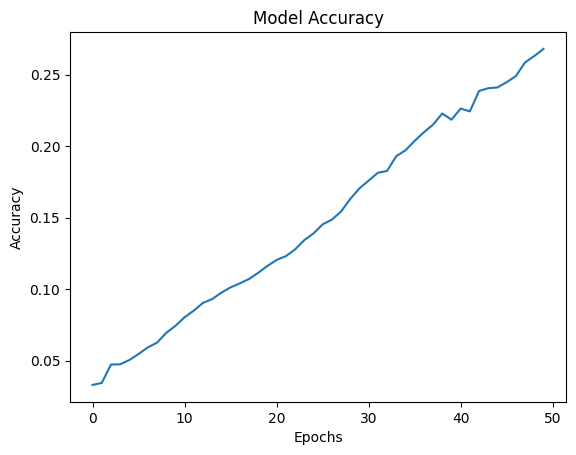

In [11]:
# plot accurcay
plt.plot(history.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [12]:
def generate_text(model, seed_text, next_words, max_sequence_len, vocab):
    for _ in range(next_words):
        token_list = vectorizer(seed_text).numpy()
        pad_sequence = np.array(tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
        choice = np.random.choice([1,2,3])

        predicted = np.argsort(model.predict(pad_sequence))[0][-choice]
        if predicted == 0:
            continue

        output_word = vocab[predicted]
        seed_text += " " + output_word
    return seed_text

text = generate_text(model, 'To be or not to be', 10, max_len, vocab)
print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
To be or not to be forgiuenesse tend from the cause in heauen lights on heauen


In [13]:
# function to train the model
def train_model(model, num_epochs, callbacks_list, train_data, train_target, shuffling = False):
    model_history = {}

    model_history = model.fit(train_data,
                                  train_target,
                                  epochs = num_epochs,
                                  callbacks = callbacks_list,
                                  shuffle = shuffling)
    return model_history

In [14]:
# define callbacks and metrics for training the model
checkpoint_path = "Model.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    save_best_only = True,
    save_weights_only = True,
    monitor = "accuracy",
    verbose = 1
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'loss',
    patience = 10,
    restore_best_weights = True)


CALLBACKS = [early_stopping_callback, checkpoint_callback]
METRICS = ['accuracy']

In [15]:
# compile and train the USE Model
tf.random.set_seed(42)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = METRICS
)

model_history = train_model(
    model, 200, CALLBACKS,
    train_data = input_sequences,
    train_target = target_sequences,
    shuffling = False
)

Epoch 1/200
797/801 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1535 - loss: 5.3751
Epoch 1: accuracy improved from -inf to 0.15289, saving model to Model.weights.h5
801/801 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.1535 - loss: 5.3736
Epoch 2/200
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1748 - loss: 4.5680
Epoch 2: accuracy improved from 0.15289 to 0.17163, saving model to Model.weights.h5
801/801 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.1748 - loss: 4.5681
Epoch 3/200
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1839 - loss: 4.4041
Epoch 3: accuracy improved from 0.17163 to 0.17862, saving model to Model.weights.h5
801/801 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.1839 - loss: 4.4042
Epoch 4/200
801/801 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1907 - loss: 4.2961
Epoch 4: accuracy improved from 0.17862 to 0.18577, saving model to Model.weights.h5
801/801 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.1907 - loss: 4.2962
Epoc

In [16]:
# download model after get weights
model.load_weights(checkpoint_path)

model.save('Model.h5')

In [18]:
def generate_text(model, seed_text, next_words, max_sequence_len, vocab):
    for _ in range(next_words):
        token_list = vectorizer(seed_text).numpy()
        pad_sequence = np.array(tf.keras.preprocessing.sequence.pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre'))
        predicted = np.argmax(model.predict(pad_sequence), axis=-1)
        if predicted == 0:
            continue

        output_word = vocab[predicted[0]]
        seed_text += " " + output_word
    return seed_text

text = generate_text(model, 'the Riuals of my Watch, bid them make', 10, max_len, vocab)
print(text)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
the Riuals of my Watch, bid them make hast go water a limbes for such for for the
